In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import warnings
from utils_func import find_max_sharpe_ratio, find_max_sharpe_ratio_weights, get_ticker_data
import pandas_datareader.data as web
warnings.filterwarnings('ignore')
np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [20]:
end = pd.Timestamp.utcnow()
start = pd.Timestamp("2019")

stocks=['GLD', 'XOM', 'SPY',
        'TLT', 'SHY', 'META']
## getting equity data for the tickers above
data = [ (symb, get_ticker_data(symb,
                            start=start, end=end)) for symb in stocks]


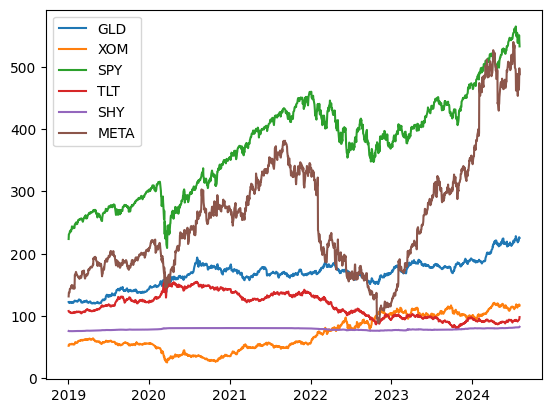

In [21]:
# data.loc[:, 'Close'].iplot(filename='prices', yTitle='price in $', world_readable=True, asDates=True)
for (symb, stock) in data:
	plt.plot(stock.Date, stock.Close, label=symb)
	plt.legend(loc="upper left")

In [22]:
return_vec = np.asmatrix([ stock["pct_change"] for (symb, stock) in data])

In [23]:
print(return_vec)

[[ 0.00906617 -0.00808624  0.00345848 ...  0.01811073 -0.00344294
  -0.00190463]
 [-0.01535385  0.0368695   0.00520043 ...  0.00355419 -0.01382915
  -0.00059854]
 [-0.02386282  0.03349581  0.00788475 ...  0.01625461 -0.01416094
  -0.01861841]
 [ 0.01137951 -0.01157501 -0.00294869 ...  0.010229    0.00862482
   0.03116149]
 [ 0.0020326  -0.00214773 -0.00071718 ...  0.00206892  0.00173025
   0.00559542]
 [-0.02903899  0.04713831  0.00072499 ...  0.02513004  0.04824886
  -0.01928713]]


Text(0, 0.5, 'returns')

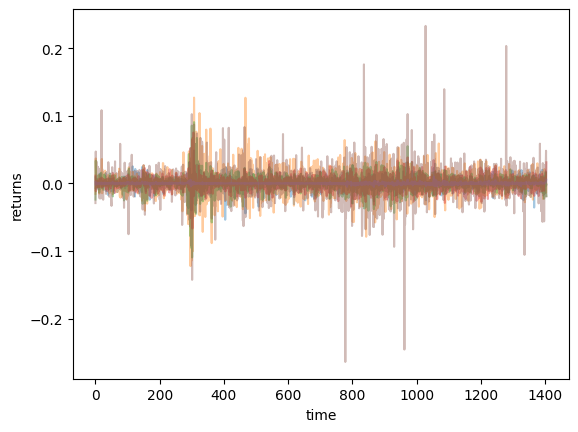

In [24]:
fig = plt.figure()
plt.plot(return_vec.T, alpha=.4)
plt.xlabel('time')
plt.ylabel('returns')



In [25]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(len(stocks)))


[0.23988467 0.09855488 0.07813438 0.18988917 0.24780647 0.14573043]


In [26]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))

    
    
    mu = w * p
    sigma = np.sqrt(w * C * w.T)


    return mu, sigma

$$
R = p^T W
$$

$R$ is the expected return, $p^T$ is the transpose of the vector for the mean returns for each time series and W is the weight vector of the portfolio. 
<br />
<br />


The standard deviation of the portfolio is 
$$
\sigma = \sqrt{W^T C W}
$$
where $C$ is the covariance matrix of the returns which is a NxN matrix.



In [27]:
## Generating the mean returns and volatility for 500 random portfolios
n_portfolios = 5000
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])


Text(0.5, 1.0, 'Mean and standard deviation of returns of portfolios')

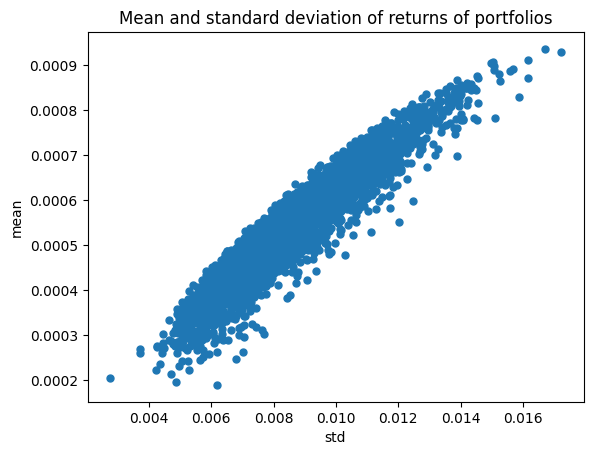

In [28]:
fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of portfolios')

We calculate the efficient frontier Markowitz-style by formalizing it as a convex optimization problem 

$$
\min_w \quad\quad W^T C W
$$

$$
s.t.\quad\quad\sum_i{W_i} = 1 
\\\
\\\

\quad\quad p^T W = \mu

$$

Here we parametrically run through $p^T W = \mu$ and find the minimum variance for different constant $\mu$‘s

In [29]:
treasury_10yr = 0.03968

In [30]:
# daily risk free interest rate
rf_rate = (1 + treasury_10yr)**(1/365) - 1
print(rf_rate)
print((1 + rf_rate)**365)


0.00010661656944011
1.039680000000031


0.0006753218995312067
0.009122635115576448


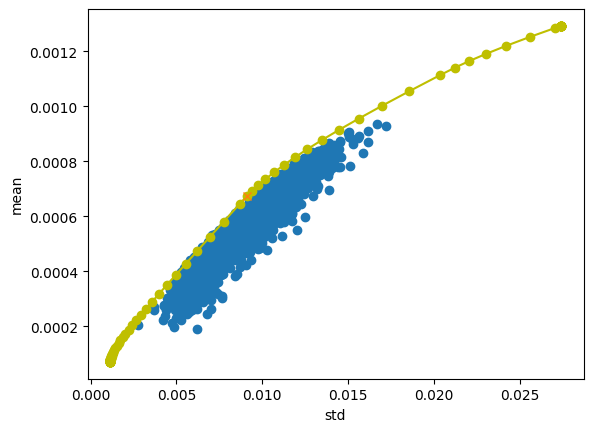

In [49]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    #print(mus)
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO with the maximum return
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    

    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)
# weights = weights.flatten()

sharp_ret, sharp_std = find_max_sharpe_ratio(returns, risks, rf_rate)
print(sharp_ret),
print(sharp_std)
fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
## plotting the optimal sharpe ratio as x
plt.plot(sharp_std, sharp_ret, 'x')
## plotting the Capital Market Line

# plt.plot([0, sharp_std], [rf_rate, sharp_ret])

In [50]:
p = np.asmatrix(np.mean(return_vec, axis=1))
print(weights)
optimal_mean =  p.T * weights 
optimal_std = np.sqrt(weights.T * np.asmatrix(np.cov(return_vec)) * weights)
print(optimal_mean)
print(optimal_std)

[[1.77818336e-07]
 [3.79034617e-08]
 [1.07282994e-07]
 [1.86275780e-07]
 [1.89514144e-07]
 [9.99999301e-01]]
[[0.00129283]]
[[0.02740103]]


## Backtesting on real market data

In [45]:
from zipline.api import ( set_benchmark,
                         set_slippage, 
                         set_commission,  
                         order_target_percent,
                         symbol
						 )
from zipline.finance import commission, slippage
from zipline import run_algorithm
import pandas_datareader.data as web

def initialize(context):
    '''
    Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables.
    
    The context object is passed to all the other methods in your algorithm.

    Parameters

    context: An initialized and empty Python dictionary that has been 
             augmented so that properties can be accessed using dot 
             notation as well as the traditional bracket notation.
    
    Returns None
    '''
    # Register history container to keep a window of the last 100 prices.
    # add_history(100, '1d', 'price')
    # Turn off the slippage model
    context.asset = symbol("AAPL")
    tickers = ['IBM', 'GLD', 'XOM', 'AAPL', 
        'MSFT', 'TLT', 'SHY', "META",'LYFT', 'BABA', 'AMZN', 'GOOG', 'TSM', 'LLY', 'AVGO', 'TSLA', 
         'JPM', 'V', 'MA', 'BAC', 'NFLX', 'PDD' ]
    context.assets = [symbol(tick) for tick in tickers]
    set_benchmark(symbol('SPY'))
    set_slippage(slippage.FixedSlippage(spread=0.0))
    # Set the commission model (Interactive Brokers Commission)
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
    #context.tick = 0
    
def handle_data(context, data):
    '''
    Called when a market event occurs for any of the algorithm's 
    securities. 

    Parameters

    data: A dictionary keyed by security id containing the current 
          state of the securities in the algo's universe.

    context: The same context object from the initialize function.
             Stores the up to date portfolio as well as any state 
             variables defined.

    Returns None
    '''
    # Allow history to accumulate 100 days of prices before trading
    # and rebalance every day thereafter.
    # context.tick += 1
    # if context.tick < 100:
    #     return
    # # Get rolling window of past prices and compute returns
    #print(data)

    prices = data.history(assets=context.assets, fields='price', bar_count=100, frequency='1d').dropna()
    #print(prices)
    returns = prices.pct_change().dropna()
    #print(prices.columns)
    
    try:
        # Perform Markowitz-style portfolio optimization
        weights, _, _ = optimal_portfolio(returns.T)
        # Rebalance portfolio accordingly
        for stock, weight in zip(prices.columns, weights):
            # print(stock)
            # print(weight)
            order_target_percent(stock, weight[0])
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass
        
start = pd.Timestamp("2019")
end = pd.Timestamp("2024-08-01")

sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()

result = run_algorithm(start=start,
                       end=end,
                       initialize=initialize,
                       handle_data=handle_data,
                       capital_base=100000,
                       benchmark_returns=benchmark_returns,
                       bundle='yahoo_csv',
                       data_frequency='daily')
# results.portfolio_value.iplot(filename='algo_perf', yTitle='Cumulative capital in $', world_readable=True, asDates=True)

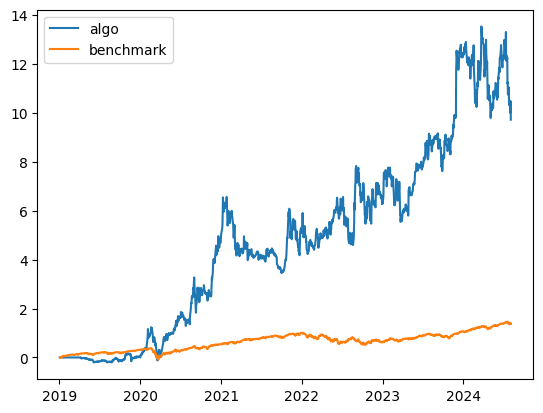

In [46]:
plt.plot(result.algorithm_period_return, label='algo')
plt.plot(result.benchmark_period_return, label='benchmark')
plt.legend(loc="upper left")

